## SegyDataset - Example
This notebook shows the functionalities of the SegyDataset and how to use them. 

This dataset is designed to be used with multiple sgy/segy files at the same time as a source or npy files (see the save and load examples below) created by this dataset. 

Args:
- data_src (str): The directory containing the SEGY files
- structured (bool : True): Indicate if data is structured or unstructured 
- mode (str : 'traces'): The mode for loading the data ['traces', 'iline', 'xline', 'time', 'cube'] 
- stack_cube (bool : true): Indicate if the cube data should be stacked if it is not -> taking the mean over the offset axis
- transform (callable, optional): Optional transform to be applied to the data on a single item (based on the mode)
- cache_size (int : -1): The size of the cache for storing loaded data (if non-positive no caching is done)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import random
from SegyDataset import SegyDataset
import json
import time

### Initialize the Dataset

In [2]:
segy_dir = 'dummy_seismic_cubes/struc'

# Test different modes
dataset_traces = SegyDataset(segy_dir, mode='traces')
print(f"Traces dataset length: {len(dataset_traces)}")
print ("============")

dataset_iline = SegyDataset(segy_dir, mode='iline')
print(f"iline dataset length: {len(dataset_iline)}")
print ("============")

dataset_xline = SegyDataset(segy_dir, mode='xline')
print(f"Crossline dataset length: {len(dataset_xline)}")
print ("============")

dataset_time = SegyDataset(segy_dir, mode='time')
print(f"Time dataset length: {len(dataset_time)}")
print ("============")

dataset_cube = SegyDataset(segy_dir, mode='cube')
print(f"Cube dataset length: {len(dataset_cube)}")
print ("============")

Traces dataset length: 74
iline dataset length: 14
Crossline dataset length: 13
Time dataset length: 110
Cube dataset length: 3


In [3]:
segy_dir_2 = 'dummy_seismic_cubes/unstruc'

# Test different modes
dataset_traces_unstruc = SegyDataset(segy_dir_2, False, mode='traces')
print(f"Traces dataset length: {len(dataset_traces)}")
print ("============")

try :
    dataset_iline_unstruc = SegyDataset(segy_dir_2, False, mode='iline')
    print(f"iline dataset length: {len(dataset_iline)}")
    print ("============")
except: 
    print ("No iline data in unstructured mode")
    print ("============")

Traces dataset length: 74
No iline data in unstructured mode


### Visualize Data

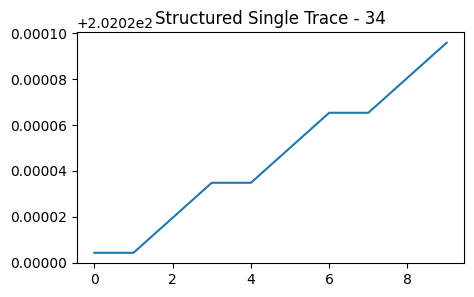

In [4]:
def plot_seismic_data(data, title):
    plt.figure(figsize=(5, 3))
    plt.imshow(data, cmap='seismic', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.show()

idx = random.randint(0, len(dataset_traces)-1)
plt.figure(figsize=(5, 3))
plt.plot(dataset_traces[idx])
plt.title('Structured Single Trace - {}'.format(idx))
plt.show()

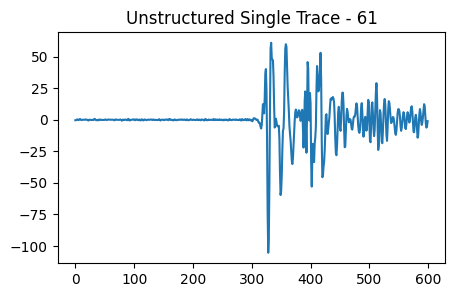

In [5]:
idx = random.randint(0, len(dataset_traces_unstruc)-1)
plt.figure(figsize=(5, 3))
plt.plot(dataset_traces_unstruc[idx])
plt.title('Unstructured Single Trace - {}'.format(idx))
plt.show()

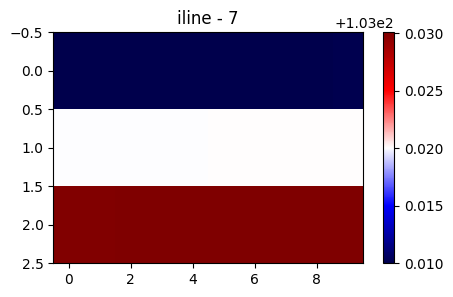

In [6]:
idx = random.randint(0, len(dataset_iline)-1)
plot_seismic_data(dataset_iline[idx], 'iline - {}'.format(idx))

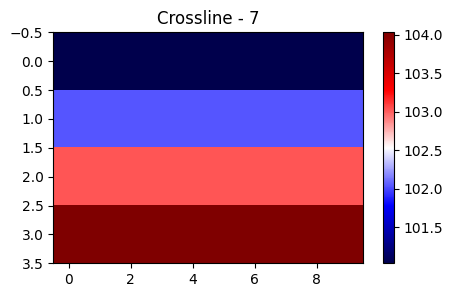

In [7]:
idx = random.randint(0, len(dataset_xline)-1)
plot_seismic_data(dataset_xline[idx], 'Crossline - {}'.format(idx))

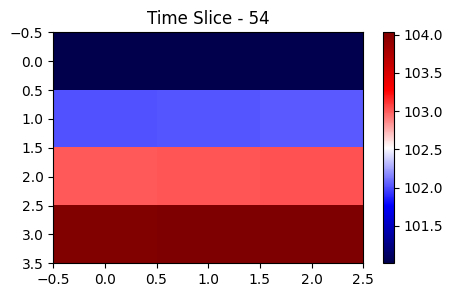

In [8]:
idx = random.randint(0, len(dataset_time)-1)
plot_seismic_data(dataset_time[idx], 'Time Slice - {}'.format(idx))

In [9]:
def plot_3d_seismic_data(data, title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot slices in the middle of each dimension
    ax1.imshow(data[data.shape[0]//2, :, :], aspect='auto', cmap='seismic')
    ax1.set_title('YZ Slice')
    ax1.set_xlabel('Y')
    ax1.set_ylabel('Z')
    
    ax2.imshow(data[:, data.shape[1]//2, :], aspect='auto', cmap='seismic')
    ax2.set_title('XZ Slice')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Z')
    
    ax3.imshow(data[:, :, data.shape[2]//2], aspect='auto', cmap='seismic')
    ax3.set_title('XY Slice')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



In [10]:
print(dataset_cube[1].shape)

The cube data was stacked to shape (4, 3, 10), from (4, 3, 2, 10)
(4, 3, 10)


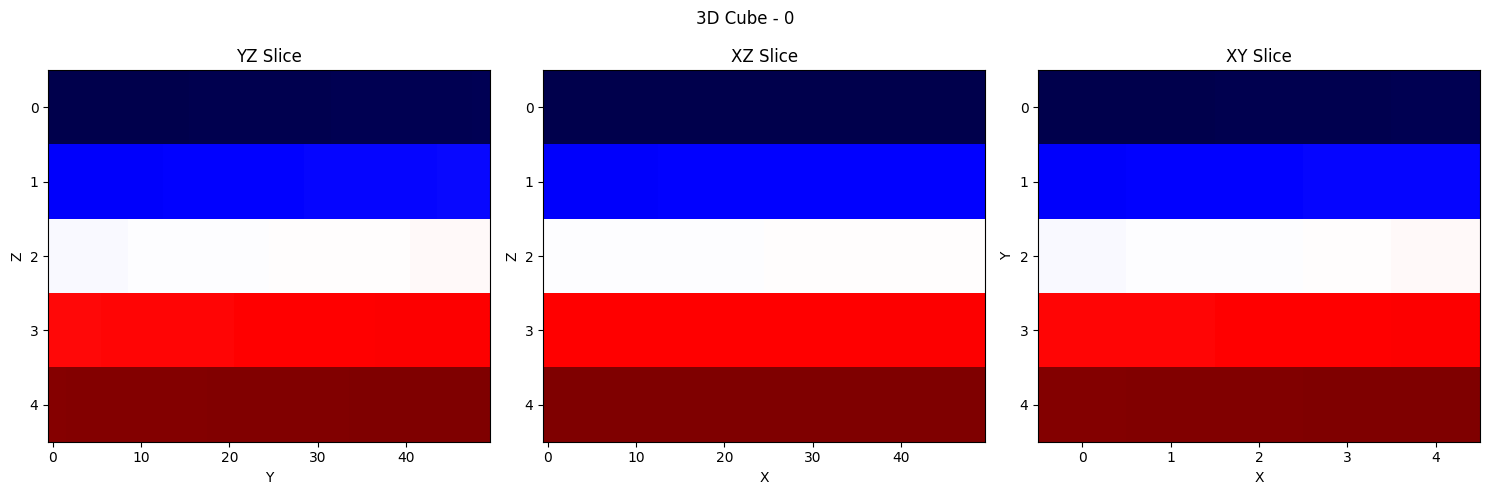

In [11]:
idx = random.randint(0, len(dataset_cube)-1)
plot_3d_seismic_data(dataset_cube[idx], '3D Cube - {}'.format(idx))

### Test with DataLoader

In [12]:
dataloader = DataLoader(dataset_traces, batch_size=8, shuffle=True, collate_fn=dataset_traces.padded_collate)

for i, batch in enumerate(dataloader):
    print(f"Batch {i+1} shape: {batch[0].shape}")
    # print (batch[0])
    if i == 2:  # Print first 3 batches
        break

Batch 1 shape: torch.Size([8, 50])
Batch 2 shape: torch.Size([8, 50])
Batch 3 shape: torch.Size([8, 50])


In [13]:
dataloader = DataLoader(dataset_iline, batch_size=8, shuffle=True, collate_fn=dataset_iline.padded_collate)

for i, batch in enumerate(dataloader):
    print(f"Batch {i+1} shape: {batch[0].shape}")
    # print (batch[0])
    if i == 2:  # Print first 5 batches
        break

Batch 1 shape: torch.Size([8, 5, 50])
Batch 2 shape: torch.Size([6, 5, 50])


In [14]:
dataloader = DataLoader(dataset_cube, batch_size=2, shuffle=True, collate_fn=dataset_cube.padded_collate)

for i, batch in enumerate(dataloader):
    print(f"Batch {i+1} shape: {batch[0].shape}")

The cube data was stacked to shape (4, 3, 10), from (4, 3, 2, 10)
Batch 1 shape: torch.Size([2, 5, 5, 50])
Batch 2 shape: torch.Size([1, 5, 5, 50])


### Test Transforms

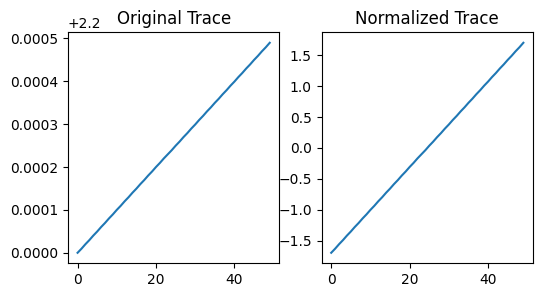

In [15]:
def normalize(data):
    return (data - np.mean(data)) / np.std(data)

dataset_with_transform = SegyDataset(segy_dir, mode='traces', transform=[normalize])
idx = random.randint(0, len(dataset_with_transform)-1)

original_trace = dataset_traces[idx]
transformed_trace = dataset_with_transform[idx]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(original_trace)
plt.title('Original Trace')
plt.subplot(1, 2, 2)
plt.plot(transformed_trace)
plt.title('Normalized Trace')
plt.show()

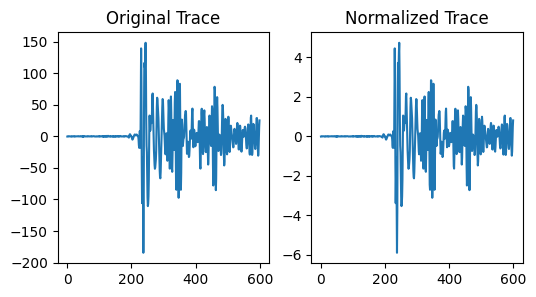

In [16]:
unstruc_dataset = SegyDataset(segy_dir_2, False, mode='traces')
unstruc_dataset_with_transform = SegyDataset(segy_dir_2, False, mode='traces', transform=[normalize])

idx = random.randint(0, len(unstruc_dataset_with_transform)-1)

original_trace = unstruc_dataset[idx]
transformed_trace = unstruc_dataset_with_transform[idx]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(original_trace)
plt.title('Original Trace')
plt.subplot(1, 2, 2)
plt.plot(transformed_trace)
plt.title('Normalized Trace')
plt.show()

### Test Error Handling

In [17]:
try:
    data = dataset_traces[len(dataset_traces)+5]
except IndexError as e:
    print(f"Caught expected error: {e}")

try:
    invalid_dataset = SegyDataset(segy_dir, mode='huh?')
except ValueError as e:
    print(f"Caught expected error: {e}")

Error accessing data at index 79: index 79 is out of bounds for axis 0 with size 74
Caught expected error: ('Invalid mode. Must be one of ', ['traces', 'iline', 'xline', 'time', 'cube'])


### Test save and load 

In [18]:
path_traces = 'dummy_npy_cubes/traces'
path_cubes = 'dummy_npy_cubes/cubes'
path_iline = 'dummy_npy_cubes/iline'
path_xline = 'dummy_npy_cubes/xline'
path_time = 'dummy_npy_cubes/time'


Saving data from file 2: 100%|██████████| 25/25 [00:00<00:00, 132899.37it/s]

Dataset saved to dummy_npy_cubes/traces
Dataset loaded from dummy_npy_cubes/traces
<SegyDataset.SegyDataset object at 0x150bf5a00> 74


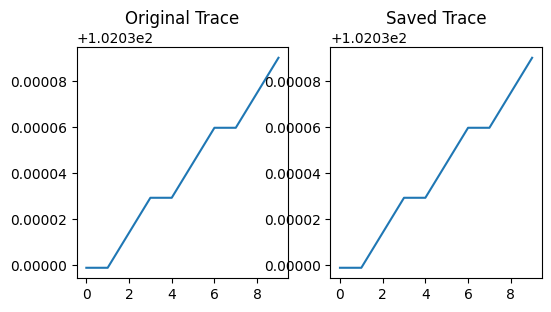

In [19]:
# save the dataset
dataset_traces.save_dataset(path_traces)
new_dataset_traces = SegyDataset.from_path(path_traces)

print (new_dataset_traces, len(new_dataset_traces))

idx = random.randint(0, len(new_dataset_traces)-1)
# plot the data from both sets side by side
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(dataset_traces[idx])
plt.title('Original Trace')

plt.subplot(1, 2, 2)
plt.plot(new_dataset_traces[idx])
plt.title('Saved Trace')
plt.show()

assert np.array_equal(dataset_traces[idx], new_dataset_traces[idx])

In [20]:
def plot_seismic_data_two(data1, data2, title):
    # plot the data from both sets side by side
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(data1, cmap='seismic', aspect='auto')
    plt.colorbar()
    plt.title('Original {}'.format(title))
    
    plt.subplot(1, 2, 2)
    plt.imshow(data2, cmap='seismic', aspect='auto')
    plt.colorbar()
    plt.title('Saved {}'.format(title))
    plt.show()


Saving data from file 2: 100%|██████████| 5/5 [00:00<00:00, 29916.58it/s]

Dataset saved to dummy_npy_cubes/iline
Dataset loaded from dummy_npy_cubes/iline


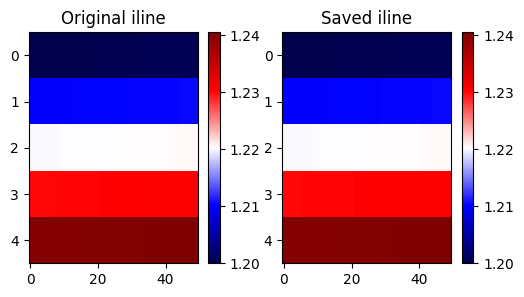

In [21]:
    
dataset_iline.save_dataset(path_iline)
new_dataset_iline = SegyDataset.from_path(path_iline)

idx = random.randint(0, len(new_dataset_iline)-1)
plot_seismic_data_two(dataset_iline[idx], new_dataset_iline[idx], 'iline')
assert np.array_equal(dataset_iline[idx], new_dataset_iline[idx])

Saving data from file 2: 100%|██████████| 5/5 [00:00<00:00, 45491.37it/s]


Dataset saved to dummy_npy_cubes/xline
Dataset loaded from dummy_npy_cubes/xline


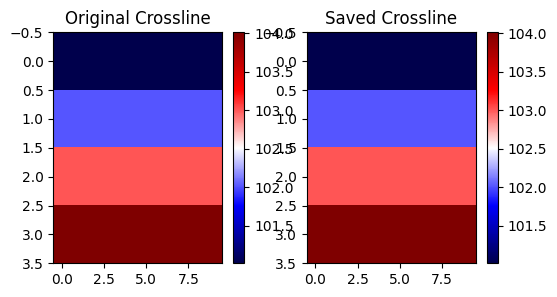

In [22]:
dataset_xline.save_dataset(path_xline)
new_dataset_xline = SegyDataset.from_path(path_xline)

idx = random.randint(0, len(new_dataset_xline)-1)
plot_seismic_data_two(dataset_xline[idx], new_dataset_xline[idx], 'Crossline')
assert np.array_equal(dataset_xline[idx], new_dataset_xline[idx])

Saving data from file 2: 100%|██████████| 50/50 [00:00<00:00, 24739.32it/s]


Dataset saved to dummy_npy_cubes/time
Dataset loaded from dummy_npy_cubes/time


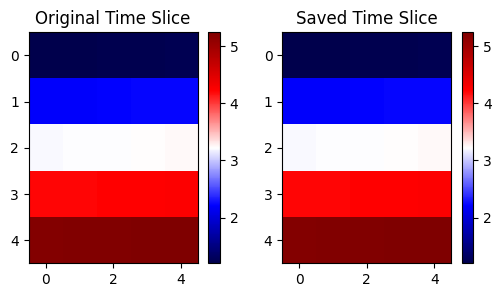

In [23]:
dataset_time.save_dataset(path_time)
new_dataset_time = SegyDataset.from_path(path_time)

idx = random.randint(0, len(new_dataset_time)-1)
plot_seismic_data_two(dataset_time[idx], new_dataset_time[idx], 'Time Slice')
assert np.array_equal(dataset_time[idx], new_dataset_time[idx])

In [24]:
path_unstruc_traces = 'dummy_npy_cubes/unstruc_traces'
path_unstruc_cubes = 'dummy_npy_cubes/unstruc_cubes'

Saving data from file 1: 100%|██████████| 480/480 [00:00<00:00, 86269.27it/s]


Dataset saved to dummy_npy_cubes/unstruc_traces
Dataset loaded from dummy_npy_cubes/unstruc_traces


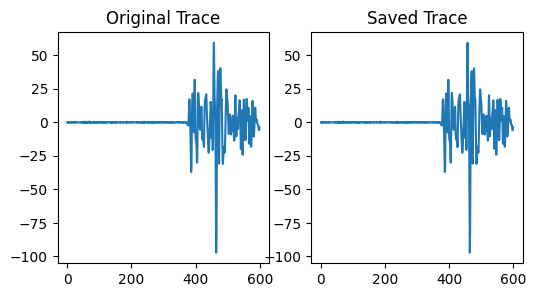

In [25]:
dataset_traces_unstruc.save_dataset(path_unstruc_traces)
new_dataset_traces_unstruc = SegyDataset.from_path(path_unstruc_traces)

idx = random.randint(0, len(new_dataset_traces_unstruc)-1)
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(dataset_traces_unstruc[idx])
plt.title('Original Trace')

plt.subplot(1, 2, 2)
plt.plot(new_dataset_traces_unstruc[idx])
plt.title('Saved Trace')
plt.show()

Saving data from file 1: 100%|██████████| 1/1 [00:00<00:00, 4391.94it/s]


The cube data was stacked to shape (4, 3, 10), from (4, 3, 2, 10)


Saving data from file 2: 100%|██████████| 1/1 [00:00<00:00, 4999.17it/s]


Dataset saved to dummy_npy_cubes/cubes
Dataset loaded from dummy_npy_cubes/cubes


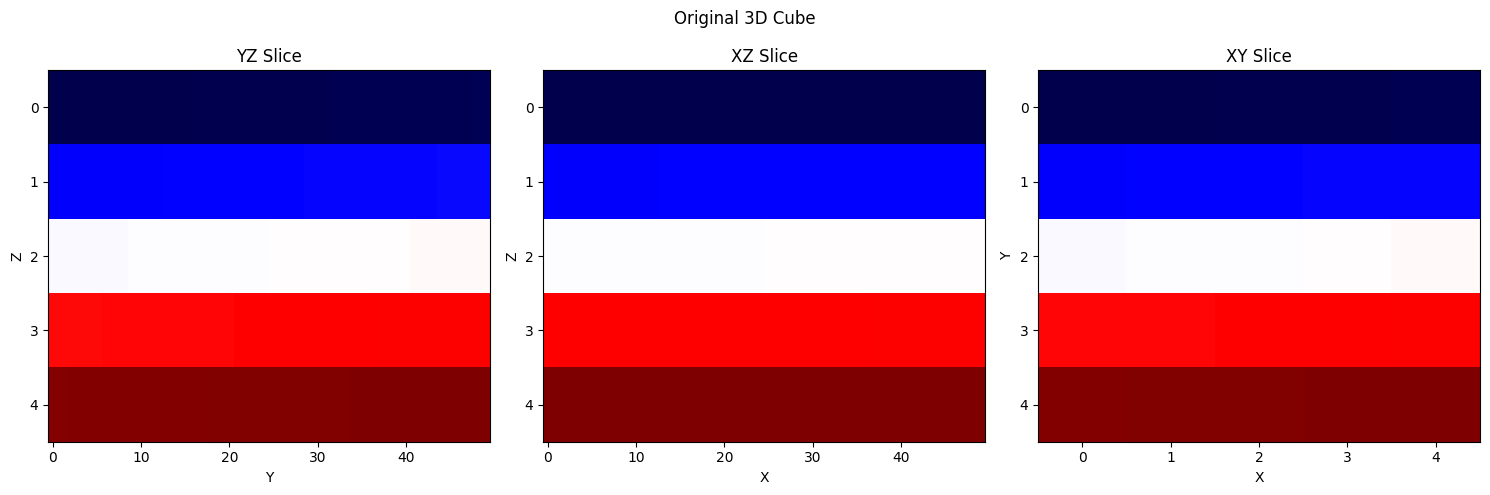

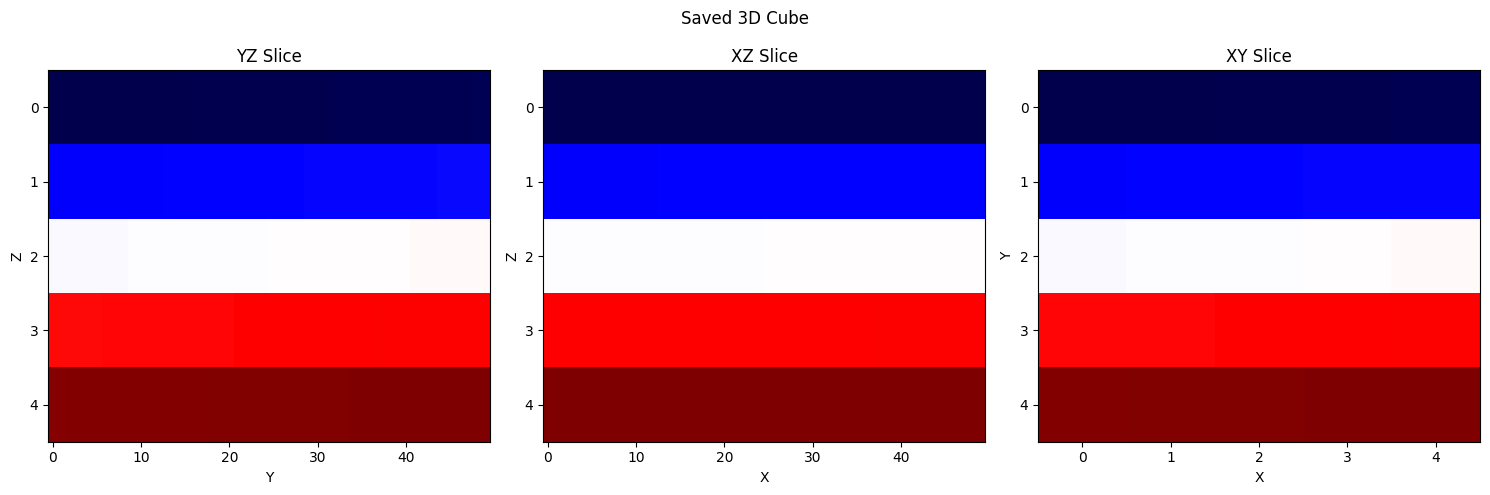

In [26]:
dataset_cube.save_dataset(path_cubes)
new_dataset_cube = SegyDataset.from_path(path_cubes)

idx = random.randint(0, len(new_dataset_cube)-1)
plot_3d_seismic_data(dataset_cube[idx], 'Original 3D Cube')
plot_3d_seismic_data(new_dataset_cube[idx], 'Saved 3D Cube')
assert np.array_equal(dataset_cube[idx], new_dataset_cube[idx])

### Test with larger cube

The path for these files is not part of the repo  

In [27]:
segy_large = 'data/struc'

In [28]:
dataset_traces = SegyDataset(segy_large, mode='traces')
print(f"Traces dataset length: {len(dataset_traces)}")
print ("============")

dataset_iline = SegyDataset(segy_large, mode='iline')
print(f"iline dataset length: {len(dataset_iline)}")
print ("============")

dataset_xline = SegyDataset(segy_large, mode='xline')
print(f"Crossline dataset length: {len(dataset_xline)}")
print ("============")

dataset_time = SegyDataset(segy_large, mode='time')
print(f"Time dataset length: {len(dataset_time)}")
print ("============")

dataset_cube = SegyDataset(segy_large, mode='cube')
print(f"Cube dataset length: {len(dataset_cube)}")
print ("============")

Traces dataset length: 619101
iline dataset length: 651
Crossline dataset length: 951
Time dataset length: 462
Cube dataset length: 1


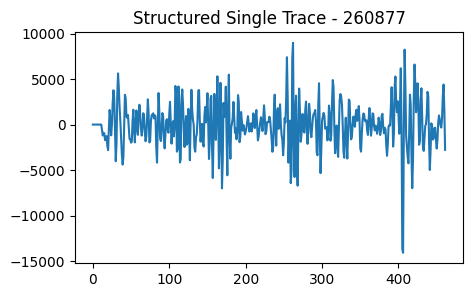

In [29]:
def plot_seismic_data(data, title):
    plt.figure(figsize=(5, 3))
    plt.imshow(data, cmap='seismic', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.show()

idx = random.randint(0, len(dataset_traces)-1)
plt.figure(figsize=(5, 3))
plt.plot(dataset_traces[idx])
plt.title('Structured Single Trace - {}'.format(idx))
plt.show()

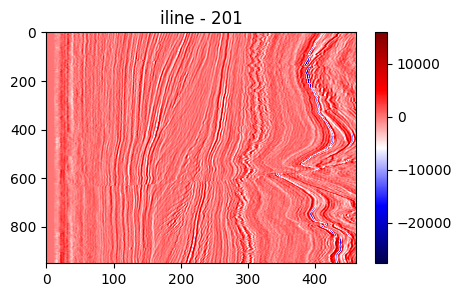

In [30]:
idx = random.randint(0, len(dataset_iline)-1)
plot_seismic_data(dataset_iline[idx], 'iline - {}'.format(idx))

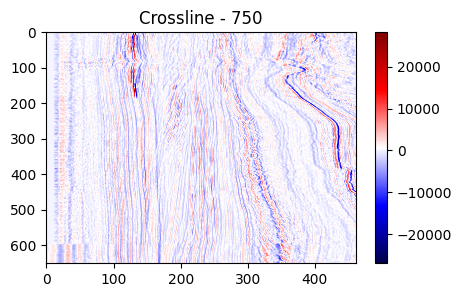

In [31]:
idx = random.randint(0, len(dataset_xline)-1)
plot_seismic_data(dataset_xline[idx], 'Crossline - {}'.format(idx))

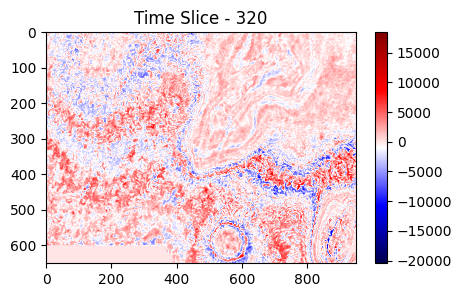

In [32]:
idx = random.randint(0, len(dataset_time)-1)
plot_seismic_data(dataset_time[idx], 'Time Slice - {}'.format(idx))

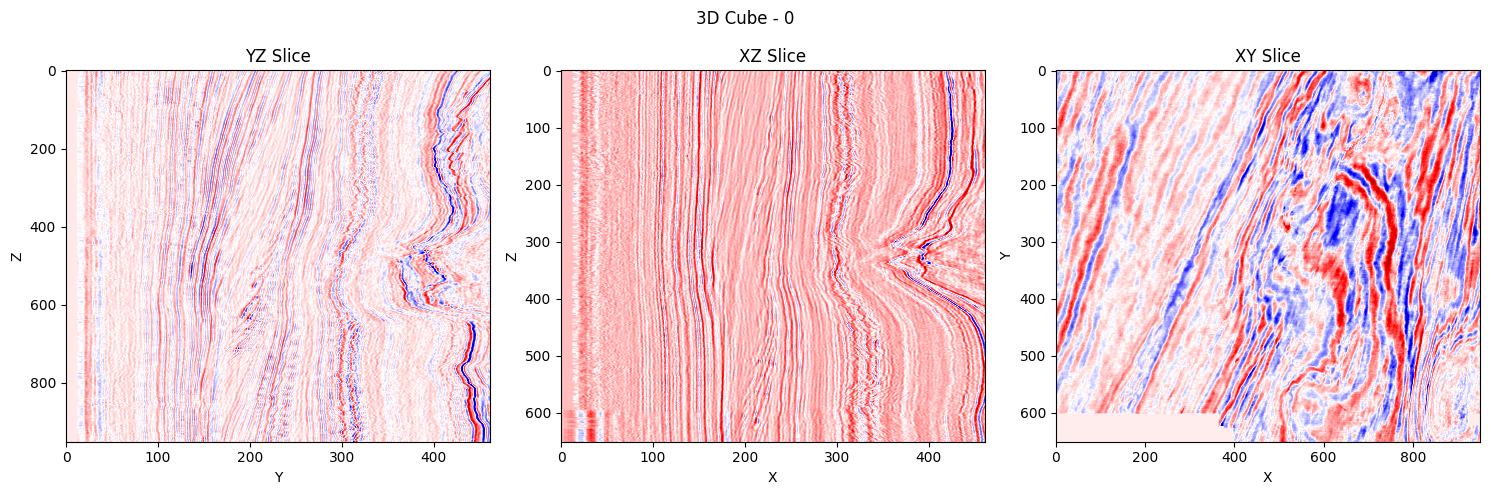

In [33]:
idx = random.randint(0, len(dataset_cube)-1)
# dataset_cube[idx], dataset_cube[0].shape
plot_3d_seismic_data(dataset_cube[idx], '3D Cube - {}'.format(idx)) #-- plotting the whole cube is too slow

In [34]:
segy_large = 'data/unstruc'

In [35]:
dataset_large_traces = SegyDataset(segy_large, mode='traces', structured=False, transform=[normalize])
print(f"Traces dataset length: {len(dataset_large_traces)}")
print ("============")


Traces dataset length: 1038162


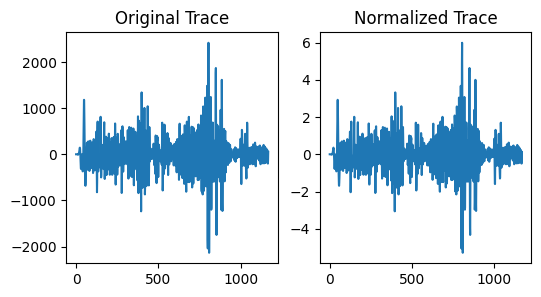

In [36]:
unstruc_dataset = SegyDataset(segy_large, mode='traces', structured=False, transform=[])
unstruc_dataset_with_transform = SegyDataset(segy_large, mode='traces', structured=False, transform=[normalize])

idx = random.randint(0, len(unstruc_dataset_with_transform)-1)

original_trace = unstruc_dataset[idx]
transformed_trace = unstruc_dataset_with_transform[idx]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(original_trace)
plt.title('Original Trace')
plt.subplot(1, 2, 2)
plt.plot(transformed_trace)
plt.title('Normalized Trace')
plt.show()

In [37]:
# cleanup memory
del dataset_traces
del dataset_iline
del dataset_xline
del dataset_time
del dataset_cube
del dataset_traces_unstruc
del dataset_with_transform
del unstruc_dataset
del unstruc_dataset_with_transform
del dataset_large_traces
del new_dataset_traces
del new_dataset_iline
del new_dataset_xline